In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [5]:
# Read dataset file
df = pd.read_csv('/content/ETH.csv')
df = df[['Price']]
df = df.dropna()
df

,Price
0,693.28
1,696.76
2,716.02
3,696.85
4,642.17
...,...
1822,1799.36
1823,1817.11
1824,1823.98
1825,1821.73


In [6]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [7]:
# Normalize the data
mean = train_data.mean()
meant = test_data.mean()
meanv = val_data.mean()
std = train_data.std()
stdt = test_data.std()
stdv = val_data.std()
train_data = (train_data - mean) / std
test_data = (test_data - meant) / stdt
val_data = (val_data - meanv) / stdv

In [8]:
# Prepare the data for CNN
window_size = 10

def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data.values, window_size)
X_test, y_test = create_sequences(test_data.values, window_size)
X_val, y_val = create_sequences(val_data.values, window_size)


In [9]:
y_train

array([[-0.29271528],
       [-0.24394726],
       [-0.25184568],
       ...,
       [ 3.40363583],
       [ 3.38662248],
       [ 3.33061797]])

In [10]:
# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [11]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/100
40/40 [==============================] - 10s 13ms/step - loss: 0.2498 - val_loss: 0.1074
Epoch 2/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0181 - val_loss: 0.0924
Epoch 3/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0159 - val_loss: 0.0896
Epoch 4/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0138 - val_loss: 0.0800
Epoch 5/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0118 - val_loss: 0.0736
Epoch 6/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0774
Epoch 7/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0724
Epoch 8/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0692
Epoch 9/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0695
Epoch 10/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 0.0591
Epoch 1

In [12]:
# Make predictions
y_pred = model.predict(X_test)
# Inverse transform the predictions
y_pred = y_pred * pd.Series(stdt).values[0] + pd.Series(meant).values[0]

12/12 [==============================] - 0s 10ms/step


In [13]:
# Make predictions
y_vpred = model.predict(X_val)
# Inverse transform the predictions
y_vpred = y_vpred * pd.Series(stdv).values[0] + pd.Series(meanv).values[0]

6/6 [==============================] - 0s 3ms/step


In [14]:
df

,Price
0,693.28
1,696.76
2,716.02
3,696.85
4,642.17
...,...
1822,1799.36
1823,1817.11
1824,1823.98
1825,1821.73


In [19]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
# re make predictions on the testing set
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
# re make predictions on the validate set
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
# calculate the RMSE
valid_rmse = np.sqrt(np.mean((y_vpred - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# calculate the MAPE
valid_mape = np.mean(np.abs((y_val - y_vpred) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Validation MAPE:", valid_mape)
print("Testing MAPE:", test_mape)

# calculate the MAE
valid_mae = np.mean(np.abs(y_vpred - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print("Validation MAE:", valid_mae)
print("Testing MAE:", test_mae)

Validation RMSE: 368.70999875033255
Testing RMSE: 1369.9085735732338
Validation MAPE: 19.86686240713354
Testing MAPE: 53.221432345711364
Validation MAE: 295.91902983231284
Testing MAE: 1091.2724922240905


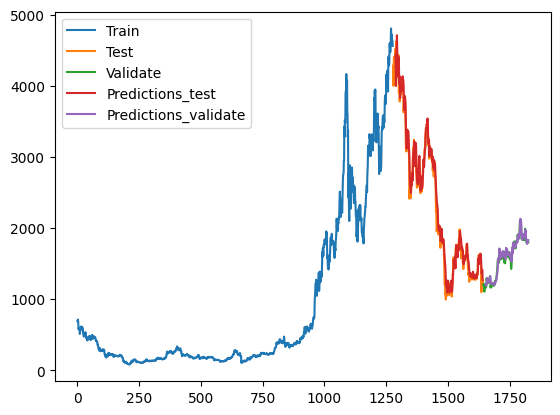

In [16]:
# ploting the actual values and predicted values
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index[-len(y_pred):], y_pred)
plt.plot(val_data.index[-len(y_vpred):], y_vpred)
plt.legend(['Train', 'Test','Validate', 'Predictions_test','Predictions_validate'])
plt.show()